In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2.Load Fraud Dataset
df = pd.read_csv("Fraud.csv")
# viewing some of the data from the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Data Cleaning

In [6]:
#so from dictionary of data we should remove isfrouadflag and sice we only need to know
#about wether it is a fraud or not we don't need name to conclude if we need we can use original dataset
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
#to check 
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


## Feature Engineering

In [7]:
df['errorOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorOrig,errorDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,1.455192e-11,-9839.64
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,-1.136868e-12,-1864.28
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0.000000e+00,-181.00
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0.000000e+00,-21363.00
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0.000000e+00,-11668.14


In [8]:
#more data cleaning since we used newbalance oldbalacnce 
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1, inplace=True)

In [9]:
df.head()

,step,type,amount,isFraud,errorOrig,errorDest
0,1,PAYMENT,9839.64,0,1.455192e-11,-9839.64
1,1,PAYMENT,1864.28,0,-1.136868e-12,-1864.28
2,1,TRANSFER,181.00,1,0.000000e+00,-181.00
3,1,CASH_OUT,181.00,1,0.000000e+00,-21363.00
4,1,PAYMENT,11668.14,0,0.000000e+00,-11668.14


In [10]:
# Encode categorical 'type' feature
df = pd.get_dummies(df, columns=['type'], drop_first=True)
# Convert any boolean columns to int (0 or 1)
df = df.astype({col: int for col in df.select_dtypes('bool').columns})


In [11]:
df.head()

,step,amount,isFraud,errorOrig,errorDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,1.455192e-11,-9839.64,0,0,1,0
1,1,1864.28,0,-1.136868e-12,-1864.28,0,0,1,0
2,1,181.00,1,0.000000e+00,-181.00,0,0,0,1
3,1,181.00,1,0.000000e+00,-21363.00,1,0,0,0
4,1,11668.14,0,0.000000e+00,-11668.14,0,0,1,0


## Corelation Heatmap

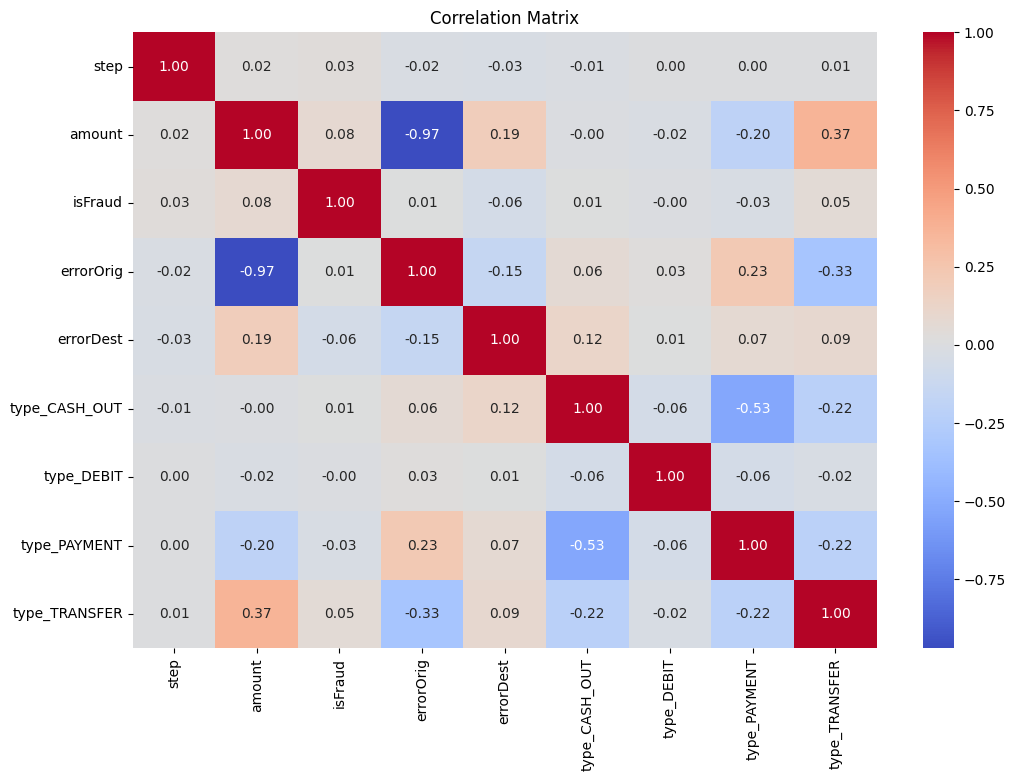

In [12]:

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Data Splitting

In [14]:
#Prepare Features and Target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

## Train and Test splitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Scaling

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Trying Different Models and evaluation

In [20]:
#Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [32]:
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))
print("Accuracy",lr.score(X_test, y_test))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.90      0.45      0.60      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.72      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270797      84]
 [    905     738]]
ROC AUC Score: 0.9900265336708646
Accuracy 0.7559880992421361


## xgBOOst classifier

In [31]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
print("Accuracy",xgb.score(X_test, y_test))


XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.92      0.74      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.87      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270771     110]
 [    424    1219]]
ROC AUC Score: 0.9856643826888362
0.9995803615491732


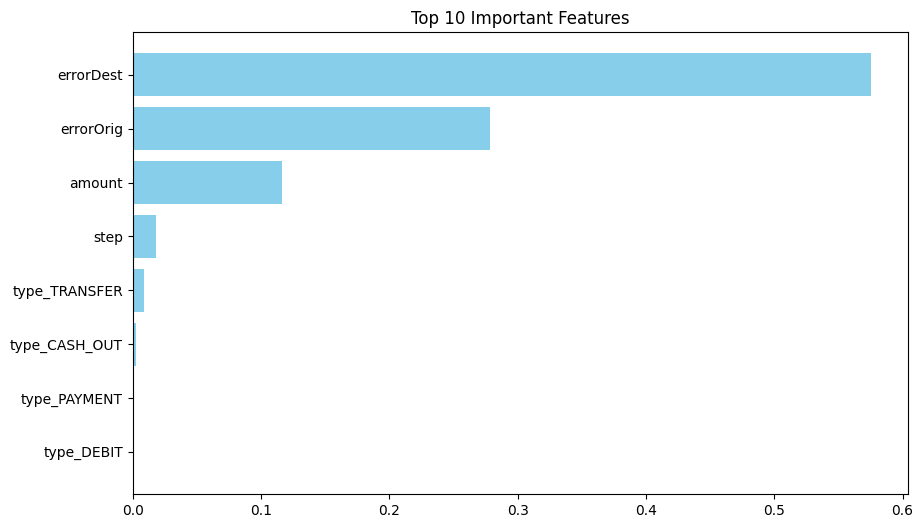

In [24]:
plt.figure(figsize=(10, 6))
importance = xgb.feature_importances_
indices = np.argsort(importance)[-10:]  # Top 10 features
plt.barh(range(len(indices)), importance[indices], color='skyblue')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title('Top 10 Important Features')
plt.show()

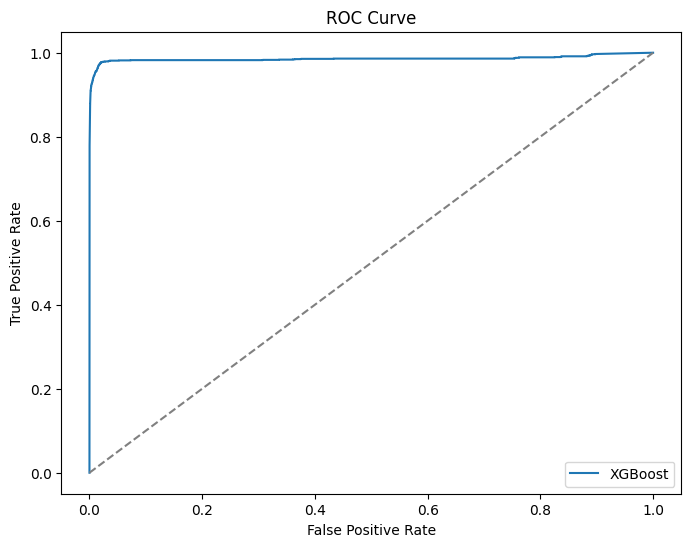

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()